# Example for 2D reconstruction

In [1]:
import scipy.io
import numpy as np
import pylops
import matplotlib.pyplot as plt
from pylops.optimization.sparsity import *

plt.close('all')

In [2]:
# load the data
mat = scipy.io.loadmat('GulfOfSuez128.mat')
data = mat["D"]
D = data[:, :, 63]
D_sqz = D.reshape(-1,order = 'C')
nt,nr = D.shape
N = nt*nr
scail = np.sqrt(1./np.prod((nt,nr)))

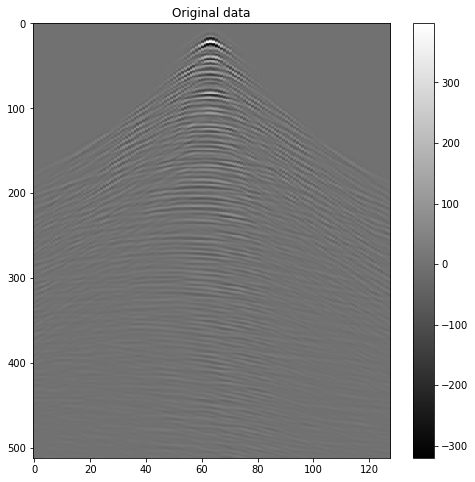

In [3]:
fig, ax = plt.subplots(figsize=(8, 8))
implot = plt.imshow(D,cmap='gray',aspect='auto')
ax.set_title('Original data')
plt.colorbar()

In [4]:
# frqeuncy spectrum
F = pylops.signalprocessing.FFT2D(dims=(nt,nr),nffts=(nt,nr))

fre = F*D.flatten()
D_adjF = F.H*fre

fre = (fre.reshape(nt, nr,order='C')) 
fre_shift = np.fft.fftshift(fre)

fre_np = np.fft.fftshift(np.fft.fft2(D))
fre_np_sqz = fre_np.reshape(-1,order='C')

In [5]:
# make Restriction operator
idr = np.arange(0,nr,2)
cod = np.arange(0,nt*nr).reshape(nt,nr)
idx = cod[:,idr].flatten()

R = pylops.Restriction(N, idx)
D_dec = R*D_sqz
D_adj = R.H*D_dec

In [6]:
# calculate derivatives from original data
# by hand
fre_sqz = F*D.flatten()

dx=10
kn=1/(2*dx)
dk=2*kn/nr
ks = np.arange(-kn,kn,dk)
ka = np.where(ks>0)
ka = ka[0]
ks_pos = ks[ka[0]:]
ks_neg = ks[0:ka[0]]
ks = np.concatenate((ks_pos,ks_neg))

dt=5e-3
fn=1/(2*dt)

coeff1 = 1j*2*np.pi*ks
coeff2 = -(2*np.pi*ks)**2

coeff1_m = np.tile(coeff1,nt)
coeff2_m = np.tile(coeff2,nt)

D1op_hand = pylops.Diagonal(coeff1_m)
D2op_hand = pylops.Diagonal(coeff2_m)

D1_hand_fre = D1op_hand*fre_sqz
D2_hand_fre = D2op_hand*fre_sqz

D1_hand = F.H*D1_hand_fre
D2_hand = F.H*D2_hand_fre


Text(0.5, 1.0, '2nd-order derivative')

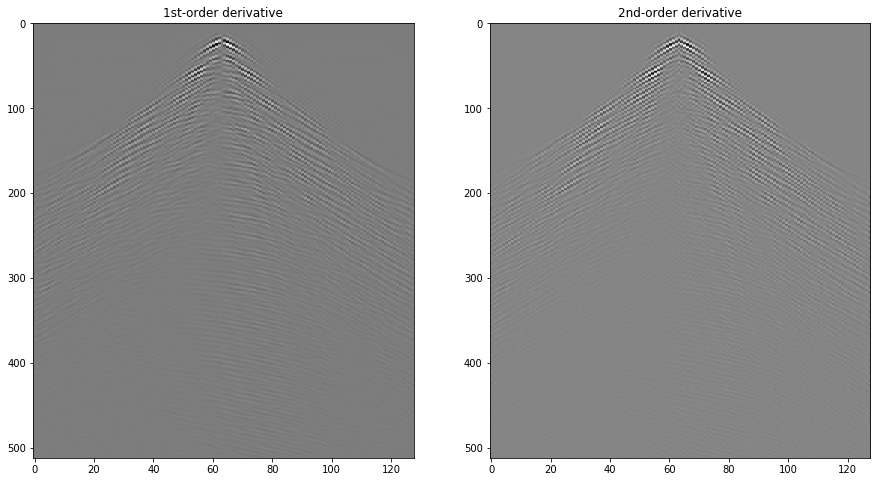

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
axs[0].imshow(np.real(D1_hand.reshape(nt,nr,order='C')),cmap='gray',aspect='auto')
axs[0].set_title('1st-order derivative')
axs[1].imshow(np.real(D2_hand.reshape(nt,nr,order='C')),cmap='gray',aspect='auto')
axs[1].set_title('2nd-order derivative')

In [8]:
# solve the linear equations
# from pylops import sparsity
D2_dec = np.real(R*(D2_hand))
D1_dec = np.real(R*(D1_hand))

# LSQR solve in Fourier domain
Forward = pylops.VStack([R*F.H, R*F.H*D1op_hand])
rhs = np.concatenate((D_dec, D1_dec))

Forward2 = pylops.VStack([R*F.H, R*F.H*D1op_hand, R*F.H*D2op_hand])
rhs2 = np.concatenate((D_dec, D1_dec, D2_dec), axis=0)

xinv = \
    pylops.optimization.leastsquares.RegularizedInversion(Forward, [], rhs, 
                                                          **dict(damp=0, iter_lim=200, show=1))

xinv2 = \
    pylops.optimization.leastsquares.RegularizedInversion(Forward2, [], rhs2, 
                                                          **dict(damp=0, iter_lim=200, show=1))
# solve with SPGL1 in Fourier domain
xinv2_s, pspgl2, info2 = SPGL1(Forward2, rhs2,returninfo=True, 
                             **dict(iterations=200))

 
LSQR            Least-squares solution of  Ax = b
The matrix A has    65536 rows  and    65536 cols
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =      200
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   3.512e+03  3.512e+03    1.0e+00  2.8e-04
     1  1.24857e+00   5.392e+02  5.392e+02    1.5e-01  1.6e-01   1.0e+00  1.0e+00
     2  1.35575e+00   4.741e+02  4.741e+02    1.3e-01  4.2e-01   1.1e+00  3.4e+00
     3  1.25779e+00   1.682e+02  1.682e+02    4.8e-02  4.5e-02   1.4e+00  9.2e+00
     4  1.25977e+00   1.679e+02  1.679e+02    4.8e-02  1.1e-02   1.7e+00  1.1e+01
     5  1.26136e+00   1.670e+02  1.670e+02    4.8e-02  1.5e-02   1.8e+00  1.5e+01
     6  1.25966e+00   1.670e+02  1.670e+02    4.8e-02  8.5e-04   2.0e+00  1.8e+01
     7  1.25978e+00   1.670e+02  1.670e+02    4.8e-02  2.2e-03   2.0e+00  2.1e+01
     8  1.25968e+00   1.670e

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pylops/basicoperators/Restriction.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  y[self.iava] = x
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/lsqr.py:544: ComplexWarning: Casting complex values to real discards the imaginary part
  str1 = '%6g %12.5e' % (itn, x[0])


    24  1.25967e+00   1.670e+02  1.670e+02    4.8e-02  8.8e-08   3.8e+00  8.0e+01
    26  1.25967e+00   1.670e+02  1.670e+02    4.8e-02  4.4e-08   3.9e+00  8.8e+01
    27  1.25967e+00   1.670e+02  1.670e+02    4.8e-02  5.7e-08   4.0e+00  9.2e+01
    28  1.25967e+00   1.670e+02  1.670e+02    4.8e-02  2.2e-08   4.1e+00  9.7e+01
    29  1.25967e+00   1.670e+02  1.670e+02    4.8e-02  2.9e-08   4.2e+00  1.0e+02
    30  1.25967e+00   1.670e+02  1.670e+02    4.8e-02  1.1e-08   4.3e+00  1.1e+02
    31  1.25967e+00   1.670e+02  1.670e+02    4.8e-02  1.5e-08   4.3e+00  1.1e+02
    32  1.25967e+00   1.670e+02  1.670e+02    4.8e-02  6.4e-09   4.4e+00  1.1e+02
 
LSQR finished
The least-squares solution is good enough, given atol     
 
istop =       2   r1norm = 1.7e+02   anorm = 4.4e+00   arnorm = 4.8e-06
itn   =      32   r2norm = 1.7e+02   acond = 1.1e+02   xnorm  = 4.8e+03
 
 
LSQR            Least-squares solution of  Ax = b
The matrix A has    98304 rows  and    65536 cols
damp = 0.0000000000

In [9]:
# making data comparisons
xinv = np.real(F.H*xinv).reshape(nt,nr)
xinv2 = np.real(F.H*xinv2).reshape(nt,nr)
xinv2_s = np.real(F.H*xinv2_s).reshape(nt,nr)

xinv_fre = np.fft.fftshift(np.fft.fft2(xinv))
xinv2_fre = np.fft.fftshift(np.fft.fft2(xinv2))
xinv2_s_fre = np.fft.fftshift(np.fft.fft2(xinv2_s))

relative = np.abs((xinv - D) / np.amax(D))
relative2 = np.abs((xinv2 - D) / np.amax(D))

relative_fre = np.abs((xinv_fre - fre_np) / np.amax(fre_np))
relative2_fre = np.abs((xinv2_fre - fre_np) / np.amax(fre_np))

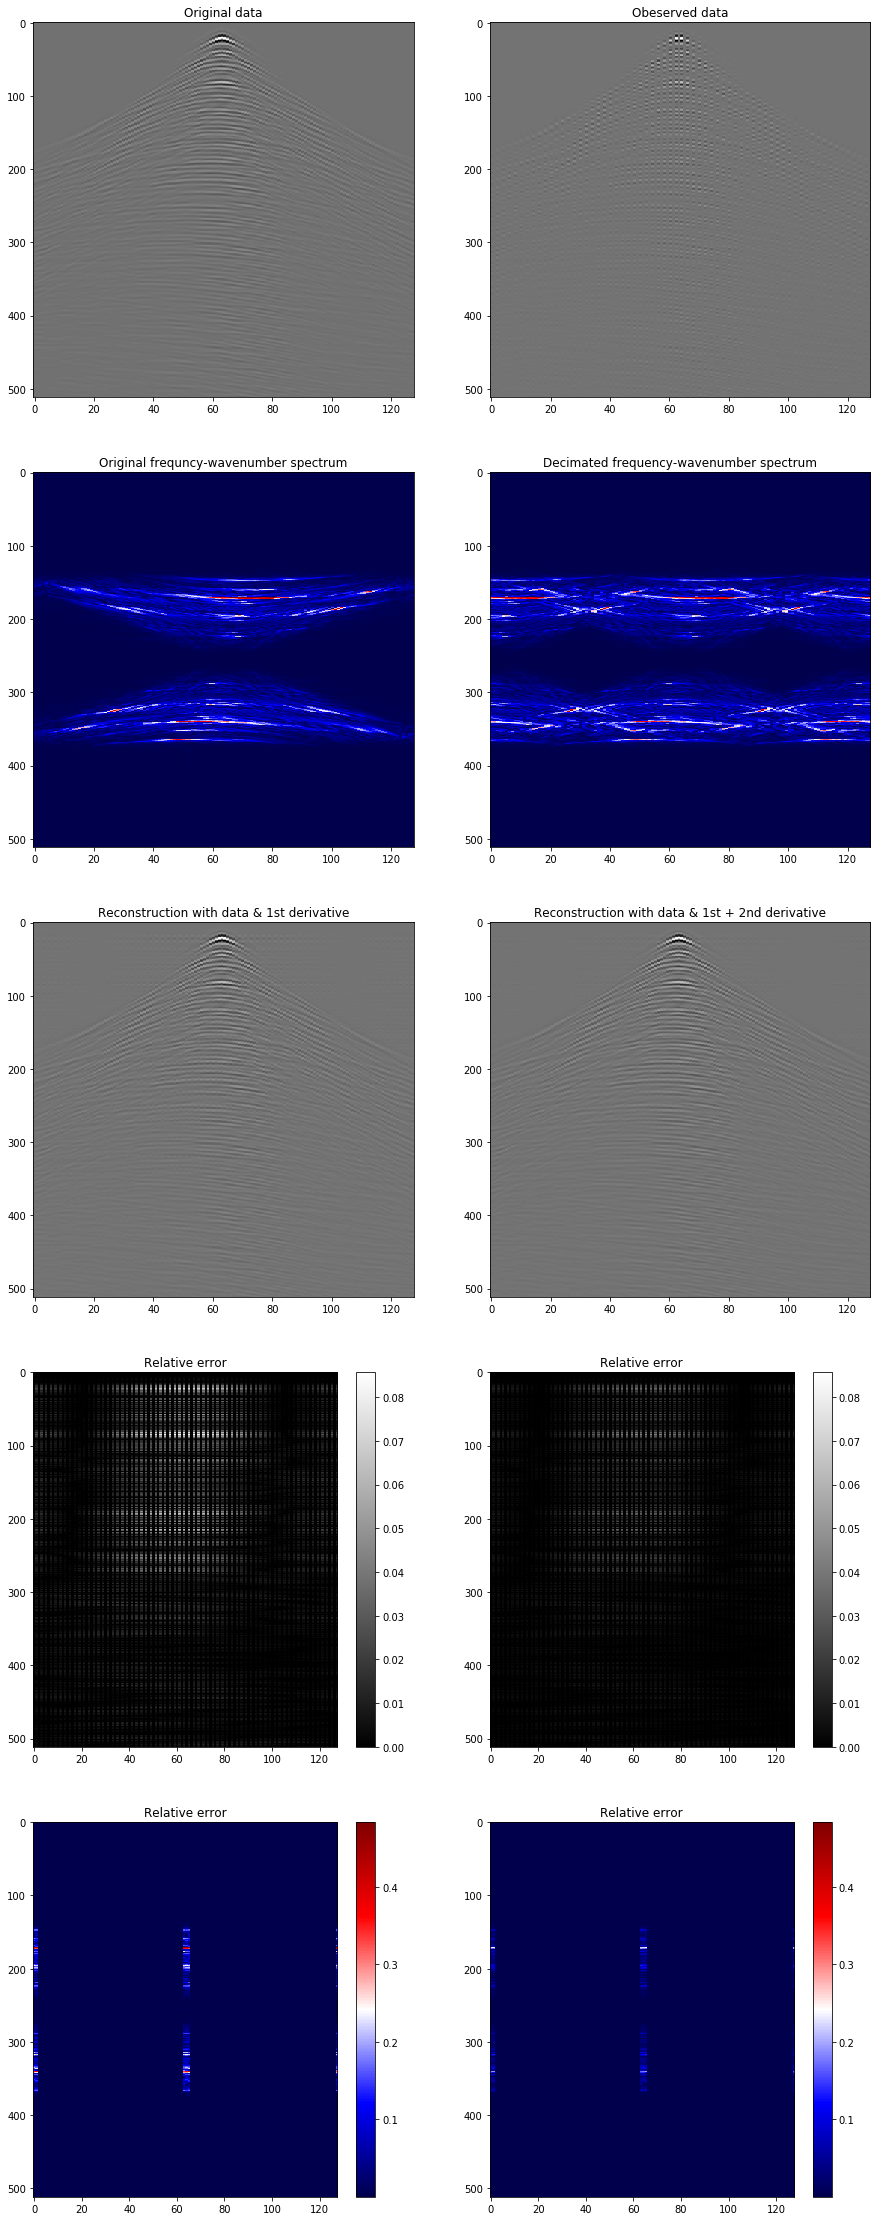

In [10]:
combined_data = np.array([relative,relative2])
t_min, t_max = np.amin(combined_data), np.amax(combined_data)

combined_data = np.array([relative_fre,relative2_fre])
f_min, f_max = np.amin(combined_data), np.amax(combined_data)

fig, axs = plt.subplots(5, 2, figsize=(15, 40))
axs[0,0].imshow(D,cmap='gray',aspect='auto')
axs[0,0].set_title('Original data')
axs[0,1].imshow(D_adj.reshape(nt,nr),cmap='gray',aspect='auto')
axs[0,1].set_title('Obeserved data')
axs[1,0].imshow(np.abs(np.fft.fftshift(fre.reshape(nt,nr))),cmap='seismic',aspect='auto')
axs[1,0].set_title('Original frequncy-wavenumber spectrum')
axs[1,1].imshow(np.abs(np.fft.fftshift(np.fft.fft2(D_adj.reshape(nt,nr)))),cmap='seismic',aspect='auto')
axs[1,1].set_title('Decimated frequency-wavenumber spectrum')
axs[2,0].imshow(np.real(xinv.reshape(nt,nr,order='C')),cmap='gray',aspect='auto')
axs[2,0].set_title('Reconstruction with data & 1st derivative')
axs[2,1].imshow(np.real(xinv2.reshape(nt,nr,order='C')),cmap='gray',aspect='auto')
axs[2,1].set_title('Reconstruction with data & 1st + 2nd derivative')

im1 = axs[3,0].imshow(relative,cmap='gray',aspect='auto',vmin=t_min, vmax =t_max)
im2 = axs[3,1].imshow(relative2,cmap='gray',aspect='auto',vmin=t_min, vmax =t_max)
fig.colorbar(im1,ax=axs[3,0])
fig.colorbar(im2,ax=axs[3,1])
axs[3,0].set_title('Relative error')
axs[3,1].set_title('Relative error')
axs[4,0].imshow(np.abs(xinv_fre),cmap='seismic',aspect='auto')
axs[4,1].imshow(np.abs(xinv2_fre),cmap='seismic',aspect='auto')
im3 = axs[4,0].imshow(relative_fre,cmap='seismic',aspect='auto',vmin=f_min, vmax =f_max)
im4 = axs[4,1].imshow(relative2_fre,cmap='seismic',aspect='auto',vmin=f_min, vmax =f_max)
axs[4,0].set_title('Relative error')
axs[4,1].set_title('Relative error')
fig.colorbar(im3,ax=axs[4,0])
fig.colorbar(im4,ax=axs[4,1])